### PREDICT CUSTOMER CREDIT SCORE

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

### IMPORTING DATA
#### import data and make a deep copy. all manipulation are performed on the copy

In [2]:
data = pd.read_excel("../SMART Banking data_4035.xlsx")

In [3]:
customer_data = data.copy(deep=True)
customer_data.columns = customer_data.iloc[0]
customer_data = customer_data[1:]
customer_data.reset_index(drop=True, inplace=True)
customer_data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,estimated_salary
0,1563462,619,France,Female,42,2,NaN,11348.88
1,15647311,68,Spain,Female,41,1,8387.86,112542.58
2,1561934,52,France,Female,42,8,15966.8,113931.57
3,1571354,699,France,Female,39,1,NaN,93826.63
4,15737888,85,Spain,Female,43,2,12551.82,7984.1


### SHAPE OF THE DATA

In [4]:
rows, columns = customer_data.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 2020, Columns: 8


### DATA EXPLORATION

### Data Types

In [5]:
dtypes_df = pd.DataFrame({
    'column': customer_data.columns,
    'datatype': customer_data.dtypes.values
})
dtypes_df

,column,datatype
0,customer_id,object
1,credit_score,object
2,country,object
3,gender,object
4,age,object
5,tenure,object
6,balance,object
7,estimated_salary,object


##### Looking at the data, customer id, credit score, age, tenure, balance, estimated salary look like numbers
##### Country, gender, tenure appear to be categorical

In [6]:
customer_data.nunique()

0
customer_id         2003
credit_score         382
country                3
gender                 2
age                   63
tenure                 9
balance             1309
estimated_salary    2016
dtype: int64

#### Missing values

In [7]:
missing_values = pd.DataFrame({
    'column': customer_data.columns,
    'no_of_missing_values': customer_data.isna().sum(),
    'percentages_of_missing_values': (customer_data.isna().sum()/len(customer_data)) * 100
})
missing_values = missing_values.reset_index(drop=True)
missing_values

,column,no_of_missing_values,percentages_of_missing_values
0,customer_id,0,0.000000
1,credit_score,11,0.544554
2,country,0,0.000000
3,gender,0,0.000000
4,age,6,0.297030
5,tenure,82,4.059406
6,balance,711,35.198020
7,estimated_salary,0,0.000000


### check for rowns without any data

In [8]:
nan_rows_count = customer_data.isna().all(axis=1).sum()
print("Rows with no data: ",int(nan_rows_count))

Rows with no data:  0


In [9]:
customer_data_without_nan = customer_data.dropna()
rows_with_nan_data = len(customer_data) - len(customer_data_without_nan)
print("Number of rows with NaN values is: ",rows_with_nan_data)
print("Percentage of rows with NaN values is: ",(rows_with_nan_data/len(customer_data))*100)

Number of rows with NaN values is:  773
Percentage of rows with NaN values is:  38.26732673267327


### Assign numbers to values in country and gender columns bacause they are categorical

In [10]:
customer_data['country'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
customer_data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [12]:
# Define mappings
country_map = {'Germany': 1, 'Spain': 2, 'France': 3}
gender_map = {'Female': 1, 'Male': 2}

# Apply mappings
customer_data['country'] = customer_data['country'].map(country_map)
customer_data['gender'] = customer_data['gender'].map(gender_map)
customer_data.head()


,customer_id,credit_score,country,gender,age,tenure,balance,estimated_salary
0,1563462,619,3,1,42,2,NaN,11348.88
1,15647311,68,2,1,41,1,8387.86,112542.58
2,1561934,52,3,1,42,8,15966.8,113931.57
3,1571354,699,3,1,39,1,NaN,93826.63
4,15737888,85,2,1,43,2,12551.82,7984.1


# REPLACEMENT OF NAN
### Column with most NaN is balance. Check if values are nomally distributed

In [13]:
from scipy.stats import shapiro

stat, p = shapiro(customer_data['balance'].dropna())
print('Shapiro-Wilk test: stat=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk test: stat=0.082, p=0.000


In [14]:
stat, p = shapiro(customer_data[customer_data['credit_score'] > 200].dropna())
print('Shapiro-Wilk test: stat=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk test: stat=0.312, p=0.000


c:\Users\HP\anaconda3\envs\msc_ds\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### p < 0.05. Data is not nomally distributed

### USE KNN TO IMPUTE MISSING VALUES
### SELECT COLUMNS TO SCALE
### Scale only continous numerical columns. DROP CUSTOMER ID COLUMN

In [15]:
numerical_cols = ['credit_score', 'age', 'balance', 'estimated_salary']   
categorical_cols = ['country', 'gender','tenure']                      

In [16]:
# Scale only numeric columns
scaler = MinMaxScaler()
scaled_numeric_data = scaler.fit_transform(customer_data[numerical_cols])

# Keep categorical columns as they are
categorical_data = customer_data[categorical_cols].values

full_data = np.hstack((scaled_numeric_data, categorical_data))

# Apply KNN imputer on full data
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(full_data)

column_names = ['credit_score', 'age', 'balance', 'estimated_salary','country', 'gender','tenure'] # ALWAYS START WITH NUMERICAL,THEN CATEGORICAL
imputed_scaled_df = pd.DataFrame(imputed_data, columns= column_names)
imputed_scaled_df.head()

,credit_score,age,balance,estimated_salary,country,gender,tenure
0,0.727488,0.5000,0.006503,0.050950,3.0,1.0,2.0
1,0.074645,0.4875,0.000585,0.505507,2.0,1.0,1.0
2,0.055687,0.5000,0.001114,0.511746,3.0,1.0,8.0
3,0.822275,0.4625,0.002656,0.421436,3.0,1.0,1.0
4,0.094787,0.5125,0.000876,0.035836,2.0,1.0,2.0


In [17]:
imputed_scaled_df.shape

(2020, 7)

In [18]:
imputed_scaled_df.isna().sum()

credit_score        0
age                 0
balance             0
estimated_salary    0
country             0
gender              0
tenure              0
dtype: int64

In [19]:
# Inverse transform to get back original scale
imputed_df = pd.DataFrame(scaler.inverse_transform(imputed_scaled_df[numerical_cols]), columns=numerical_cols)
imputed_df.head()


,credit_score,age,balance,estimated_salary
0,619.0,42.0,93101.008,11348.88
1,68.0,41.0,8387.860,112542.58
2,52.0,42.0,15966.800,113931.57
3,699.0,39.0,38038.282,93826.63
4,85.0,43.0,12551.820,7984.10


In [20]:
imputed_scaled_df.update(imputed_df)
imputed_scaled_df.head()


,credit_score,age,balance,estimated_salary,country,gender,tenure
0,619.0,42.0,93101.008,11348.88,3.0,1.0,2.0
1,68.0,41.0,8387.860,112542.58,2.0,1.0,1.0
2,52.0,42.0,15966.800,113931.57,3.0,1.0,8.0
3,699.0,39.0,38038.282,93826.63,3.0,1.0,1.0
4,85.0,43.0,12551.820,7984.10,2.0,1.0,2.0


In [21]:
imputed_scaled_df[['country','gender','tenure','age']] = imputed_scaled_df[['country','gender','tenure','age']].astype(int)

In [22]:
customer_data = imputed_scaled_df

### DELETE REDUNDANT VARIABLES TO FREE UP SPACE

In [23]:
import gc
del imputed_data, imputed_df, imputed_scaled_df,categorical_data, scaled_numeric_data, full_data,column_names
del gender_map, country_map, scaler, imputer, numerical_cols, categorical_cols

gc.collect()

114

In [24]:
missing_values = pd.DataFrame({
    'column': customer_data.columns,
    'no_of_missing_values': customer_data.isna().sum(),
    'percentages_of_missing_values': (customer_data.isna().sum()/len(customer_data)) * 100
})
missing_values = missing_values.reset_index(drop=True)
missing_values

,column,no_of_missing_values,percentages_of_missing_values
0,credit_score,0,0.0
1,age,0,0.0
2,balance,0,0.0
3,estimated_salary,0,0.0
4,country,0,0.0
5,gender,0,0.0
6,tenure,0,0.0


In [25]:
#customer_data.to_csv("customer_data_cleaned.csv", index=False)

In [26]:
country_map = {'Germany': 1, 'Spain': 2, 'France': 3}
germany_data = customer_data[customer_data['country'] == 1]
spain_data = customer_data[customer_data['country'] == 2]
france_data = customer_data[customer_data['country'] == 3]

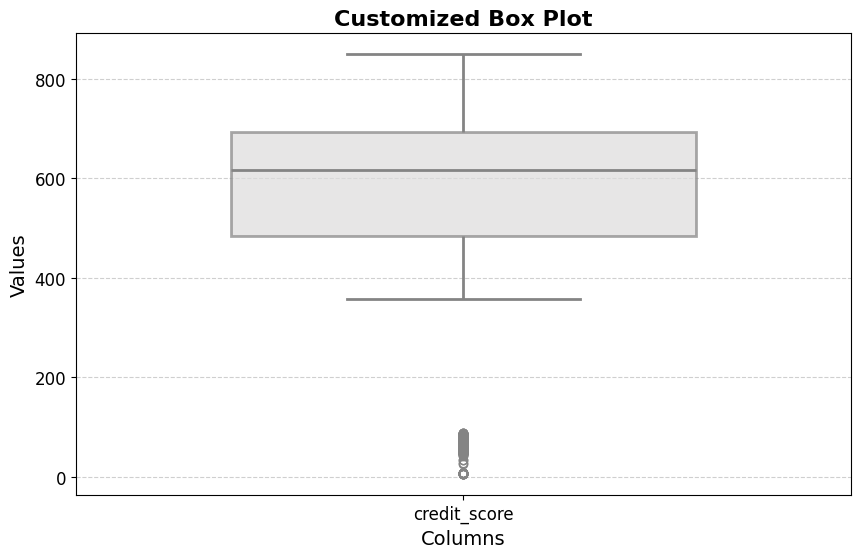

In [27]:
# Create a figure
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_data[['credit_score']], palette="coolwarm", width=0.6, linewidth=2, boxprops={'alpha':0.7})

# Customize aesthetics
plt.title("Customized Box Plot", fontsize=16, fontweight="bold", color="black")
plt.xlabel("Columns", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)

# Grid for better readability
plt.grid(axis='y', linestyle="--", alpha=0.6)

# Show the plot
plt.show()

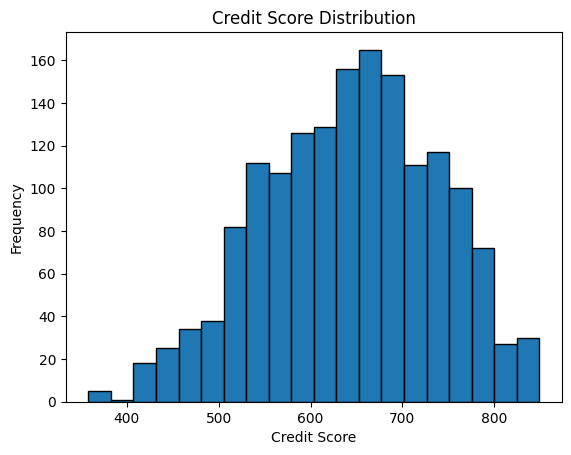

In [28]:
# Plot histogram
customer_data['credit_score'][customer_data['credit_score'] > 200].hist(bins=20, edgecolor='black')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


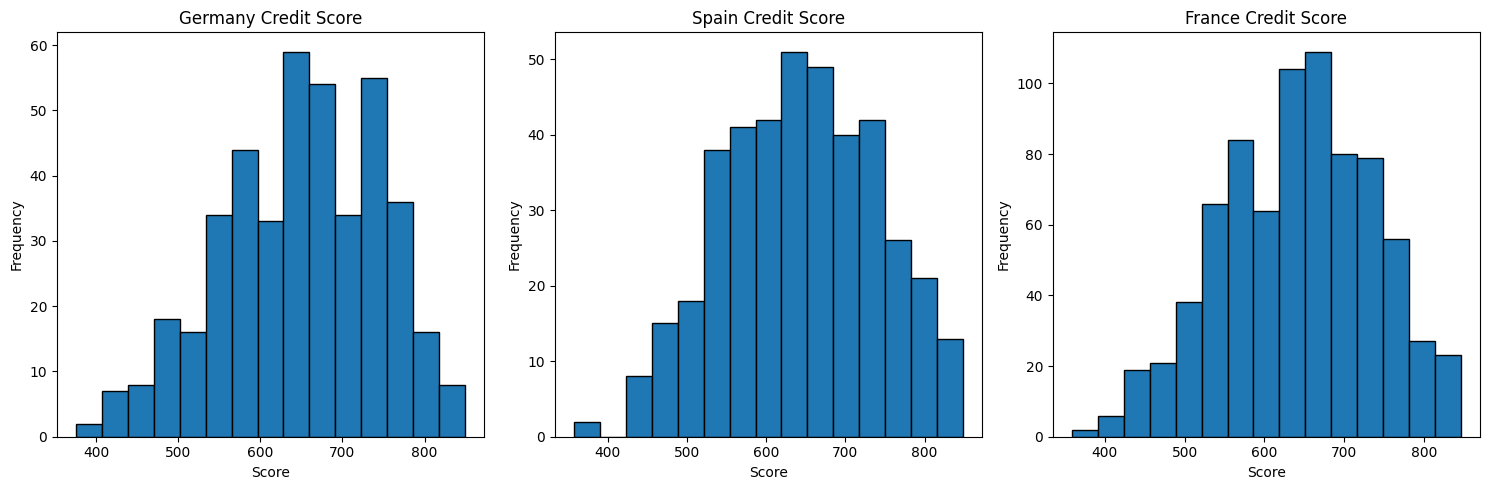

In [29]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First histogram
axes[0].hist(germany_data['credit_score'][germany_data['credit_score'] > 200],bins=15, edgecolor='black')
axes[0].set_title('Germany Credit Score')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Second histogram
axes[1].hist(spain_data['credit_score'][spain_data['credit_score'] > 200],bins=15, edgecolor='black')
axes[1].set_title('Spain Credit Score')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')

# Third histogram
axes[2].hist(france_data['credit_score'][france_data['credit_score'] > 200], bins=15, edgecolor='black')
axes[2].set_title('France Credit Score')
axes[2].set_xlabel('Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [30]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Example DataFrame
# # df = pd.read_csv('your_data.csv')

# plt.figure(figsize=(10, 6))

# plt.hist(germany_data['credit_score'][germany_data['credit_score'] > 200], bins=20, alpha=0.5, label='Credit Score', edgecolor='black')
# plt.hist(spain_data['credit_score'][spain_data['credit_score'] > 200], bins=20, alpha=0.5, label='Income', edgecolor='black')
# plt.hist(france_data['credit_score'][france_data['credit_score'] > 200], bins=20, alpha=0.5, label='Loan Amount', edgecolor='black')

# plt.title('Comparison of Credit Score, Income, and Loan Amount')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(False)
# plt.show()


### FOR DATA WITH CREDIT SCORES BELOW 200

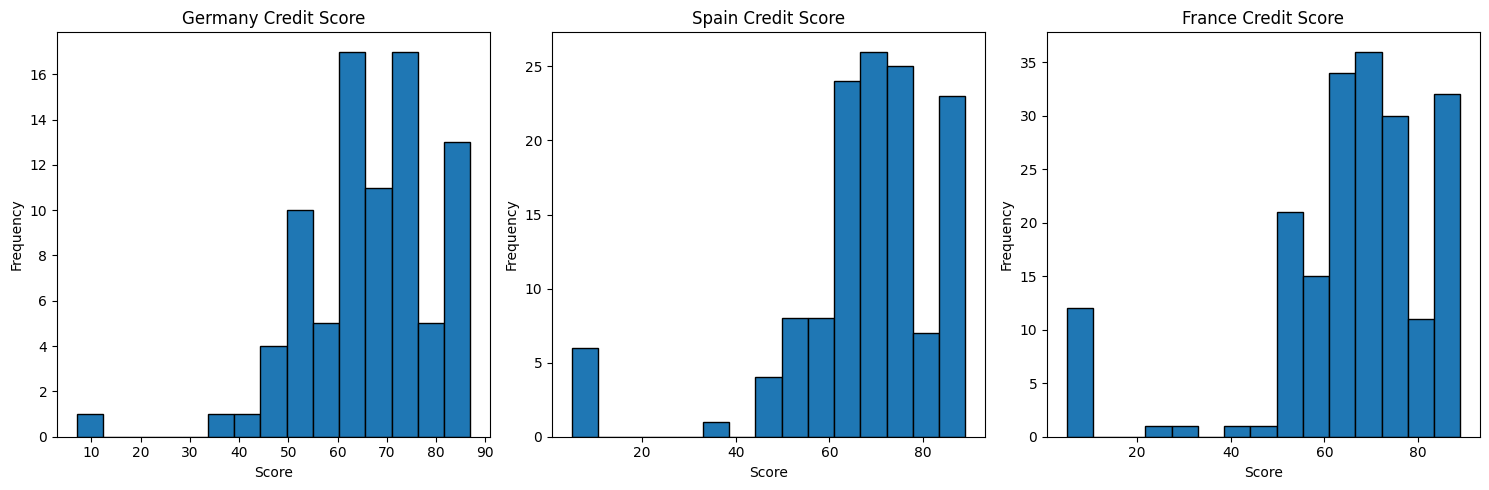

In [31]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First histogram
axes[0].hist(germany_data['credit_score'][germany_data['credit_score'] < 200],bins=15, edgecolor='black')
axes[0].set_title('Germany Credit Score')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Second histogram
axes[1].hist(spain_data['credit_score'][spain_data['credit_score'] < 200],bins=15, edgecolor='black')
axes[1].set_title('Spain Credit Score')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')

# Third histogram
axes[2].hist(france_data['credit_score'][france_data['credit_score'] < 200], bins=15, edgecolor='black')
axes[2].set_title('France Credit Score')
axes[2].set_xlabel('Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [32]:
stat, p = shapiro(germany_data[germany_data['credit_score'] > 200])
print('Shapiro-Wilk test: stat=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk test: stat=0.040, p=0.000


In [33]:
stat, p = shapiro(france_data[france_data['credit_score'] > 200])
print('Shapiro-Wilk test: stat=%.3f, p=%.3f' % (stat, p))

Shapiro-Wilk test: stat=0.387, p=0.000


c:\Users\HP\anaconda3\envs\msc_ds\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [34]:
len(customer_data[customer_data['credit_score'] < 100])

412

In [35]:
len(customer_data[customer_data['credit_score'] < 200])

412

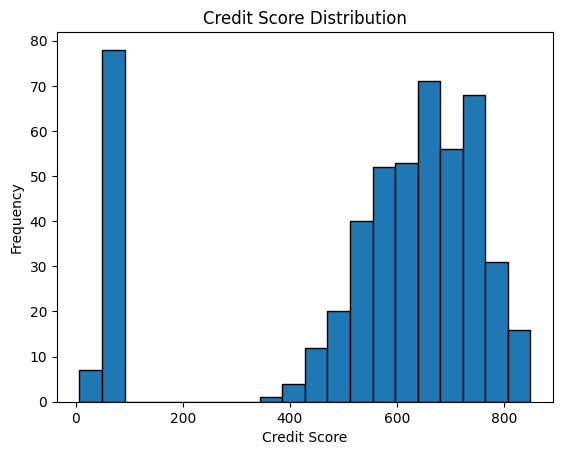

In [36]:
# Plot histogram
germany_data['credit_score'].hist(bins=20, edgecolor='black')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


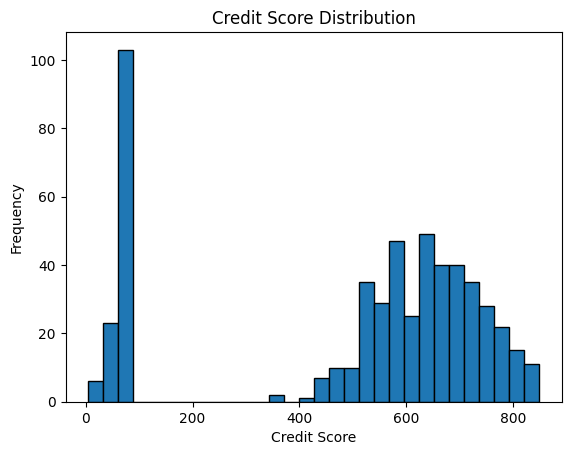

In [37]:
# Plot histogram
spain_data['credit_score'].hist(bins=30, edgecolor='black')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [38]:
low_score = customer_data[customer_data['credit_score'] < 200]
low_score.country.value_counts()

country
3    195
2    132
1     85
Name: count, dtype: int64

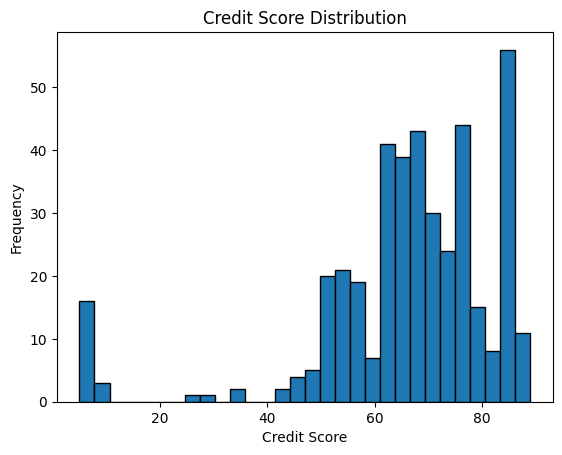

In [39]:
# Plot histogram
low_score['credit_score'].hist(bins=30, edgecolor='black')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [40]:
germany_data.credit_score.value_counts()

credit_score
85.0     10
756.0     6
61.0      6
54.0      5
659.0     5
         ..
498.0     1
459.0     1
583.0     1
688.0     1
753.0     1
Name: count, Length: 256, dtype: int64

In [41]:
# france_data.to_csv("cleaned_data/france_customer_data.csv")
# spain_data.to_csv("cleaned_data/spain_customer_data.csv")
# germany_data.to_csv("cleaned_data/germany_customer_data.csv")

## PCA ANALYSIS

In [42]:
# Select only numerical columns
pca_data = pd.read_csv("cleaned_data/customer_data_cleaned.csv ")
numerical_cols = pca_data.select_dtypes(include=['float64', 'int64']).columns

# Example: print them
print(numerical_cols)

# Create a new DataFrame with only numerical data
X = pca_data[numerical_cols]


Index(['credit_score', 'age', 'balance', 'estimated_salary', 'country',
       'gender', 'tenure'],
      dtype='object')


In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [44]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA()

# Fit PCA on scaled data
pca.fit(X_scaled)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Print explained variance for each component
for i, var in enumerate(explained_variance):
    print(f'PC{i+1}: {var:.2%}')


PC1: 15.65%
PC2: 14.98%
PC3: 14.67%
PC4: 14.51%
PC5: 14.07%
PC6: 13.21%
PC7: 12.91%


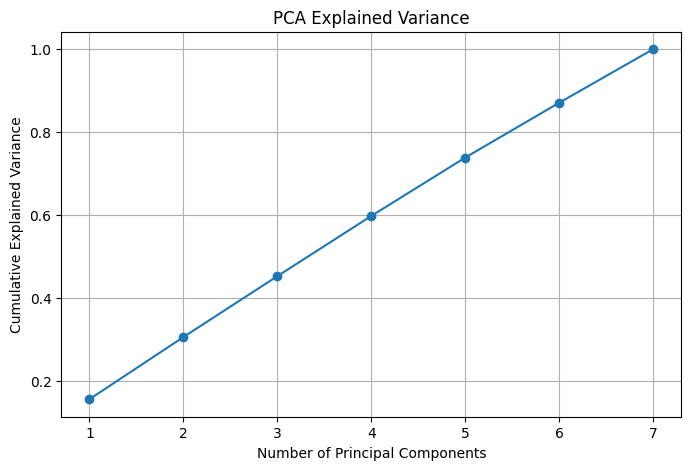

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


### CHECK FOR OUTLIERS. BOTH ON LOWER AND UPPER SIDE 

In [ ]:
# Example column
col = 'credit_score'  # change to your column name

# Calculate Q1, Q3 and IQR
Q1 = customer_data[col].quantile(0.25)
Q3 = customer_data[col].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
#outliers = customer_data[(customer_data[col] < lower_bound) | (customer_data[col] > upper_bound)]
low_outliers = customer_data[(customer_data[col] < lower_bound)]
high_outliers = customer_data[(customer_data[col] > upper_bound)]
print(f'Found {len(low_outliers)} low side outliers in column "{col}".')
print(f'Found {len(high_outliers)} high side outliers in column "{col}".')



Found 412 outliers in column "credit_score".
Found 0 outliers in column "credit_score".


In [50]:
print((len(low_outliers)/len(customer_data))*100)

20.396039603960396


In [ ]:
germany_low_outliers = germany_data[(germany_data[col] < lower_bound)]
germany_high_outliers = germany_data[(germany_data[col] > upper_bound)]
print(f'Found {len(germany_low_outliers)} low side outliers ')
print(f'Found {len(germany_high_outliers)} high side outliers')

Found 85 low side outliers in column "credit_score".
Found 0 high side outliers in column "credit_score".


In [ ]:
germany_low_outliers = germany_data[(germany_data[col] < lower_bound)]
germany_high_outliers = germany_data[(germany_data[col] > upper_bound)]
print(f'Found {len(germany_low_outliers)} low side outliers ')
print(f'Found {len(germany_high_outliers)} high side outliers')

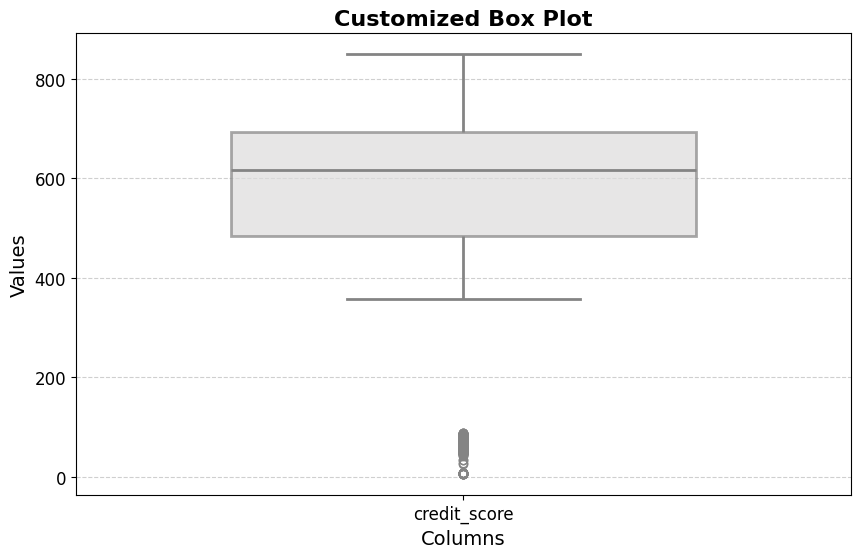

In [47]:
# Create a figure
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_data[['credit_score']], palette="coolwarm", width=0.6, linewidth=2, boxprops={'alpha':0.7})

# Customize aesthetics
plt.title("Customized Box Plot", fontsize=16, fontweight="bold", color="black")
plt.xlabel("Columns", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)

# Grid for better readability
plt.grid(axis='y', linestyle="--", alpha=0.6)

# Show the plot
plt.show()